# Context managers

## The sad story of a neuroscientist and her electron microscope

Let's pretend we got a night slot to use a powerful scanning electron microscope (SEM), and we want to use it to scan a brain sample.

We want to write a Python script to run during that slot that performs the scan automatically using the microscope API (so we can sleep instead of being at the lab).

First, we import what we need from the API:

In [1]:
from microscope import (
    MicroscopeState,  # Object that holds the current state of the microscope

    connect_to_microscope,  # Connect to microscope and get a state object
    release_microscope,

    activate_vacuum_pump,  # Make vacuum inside the microscope 
    deactivate_vacuum_pump,
    
    insert_sample,  # Insert sample for scanning
    remove_sample,
    
    calibrate,  # Calibrate microscope
    scan_sample,  # Scan sample currently in the microscope
)

This is the script that we came up with:

In [2]:
# To be run at 2AM using 'cron'
microscope_state = connect_to_microscope()
activate_vacuum_pump(microscope_state)
calibration_image = calibrate(microscope_state)
sample_image = scan_sample(microscope_state)
deactivate_vacuum_pump(microscope_state)
release_microscope(microscope_state)

Connected to microscope
Vacuum pump activated
... done.


RuntimeError: Probe not present

Duh! We forgot to insert the brain sample.

That's horrible:

1) We still don't have the data

2) The vacuum was not released and the vacuum pump overheated over a few hours. The SEM is going to be offline for a couple of days until it's fixed :-(

We're not easily discouraged so we decide to fix the script:

In [3]:
# The script, complete
microscope_state = connect_to_microscope()
activate_vacuum_pump(microscope_state)

insert_sample(microscope_state)
sample_image = scan_sample(microscope_state)
remove_sample(microscope_state)

deactivate_vacuum_pump(microscope_state)
release_microscope(microscope_state)

Connected to microscope
Vacuum pump activated
Probe inserted
Scanning probe...
... done.
Probe removed
Vacuum pump deactivated
Microscope released


Still, if anything goes wrong 1) the vacuum pump might continue running or 2) the microscope connection might not be released, forcing some collagues to give up their slots.

What should we do to make sure that the microscope is always left in a decent state?

In [4]:
# The script, complete and safe
microscope_state = connect_to_microscope()

activate_vacuum_pump(microscope_state)
try:
    insert_sample(microscope_state)
    try:
        sample_image = scan_sample(microscope_state)
    finally:
        remove_sample(microscope_state)
finally:
    deactivate_vacuum_pump(microscope_state)

release_microscope(microscope_state)

Connected to microscope
Vacuum pump activated
Probe inserted
Scanning probe...
... done.
Probe removed
Vacuum pump deactivated
Microscope released


Of course, we could define a function `safe_scan_image()` that does all of that and hides the complexity away, but the initial and final parts in the function will show up in a lot of similar functions (e.g. the one below). 

In [5]:
# Script to collect a calibration image from the microscope.
# Another example of a microscope script that needs to do something similar but different.
microscope_state = connect_to_microscope()

activate_vacuum_pump(microscope_state)
try:
    calibration_image = calibrate(microscope_state)
finally:
    deactivate_vacuum_pump(microscope_state)
    
release_microscope(microscope_state)

Connected to microscope
Vacuum pump activated
... done.
Vacuum pump deactivated
Microscope released


## How to define a context manager

We would like to write something like this:

```
with do_stuff_under_vacuum(microscope_state):
    calibration_image = calibrate(microscope_state)
```

so that 1) the vacuum pump is activated before the code is executed; 2) the vacuum pump is deactivated, no matter if the code executes or fails.

That is what context managers are for!

In [9]:
def do_stuff_under_vacuum(microscope_state):
    activate_vacuum_pump(microscope_state)
    try:
        return microscope_state
        # Here do some stuff with microscope_state
        # Come back here
    finally:
        deactivate_vacuum_pump(microscope_state)

# But "return" makes the function quits... we've seen "yield" though!

We can use the `yield` keyword together with the `@contextmanager` to define a "context manager":

In [10]:
from contextlib import contextmanager

@contextmanager
def do_stuff_under_vacuum(microscope_state):
    activate_vacuum_pump(microscope_state)
    try:
        yield  # The control is returned, and a block of code is executed
        # The context manager continues from this point when the block of code exits
    finally:
        deactivate_vacuum_pump(microscope_state)



In [11]:
microscope_state = connect_to_microscope()

with do_stuff_under_vacuum(microscope_state):
    calibration_image = calibrate(microscope_state)

release_microscope(microscope_state)

Connected to microscope
Vacuum pump activated
... done.
Vacuum pump deactivated
Microscope released


## Hands-on 1

Submit a PR for Issue #1 on GitHub.

In [13]:
@contextmanager
def sample_inserted(microscope_state):
    insert_sample(microscope_state)
    try:
        yield
    finally:
        remove_sample(microscope_state)


microscope_state = connect_to_microscope()

with do_stuff_under_vacuum(microscope_state):
    with sample_inserted(microscope_state):
        sample_image = scan_sample(microscope_state)

release_microscope(microscope_state)


Connected to microscope
Vacuum pump activated
Probe inserted
Scanning probe...
... done.
Probe removed
Vacuum pump deactivated
Microscope released


## Context managers can return a value

Now that we're hooked to context managers, we would like to handle the connection to the microscope the same way: we'd like to write a context manager that connects to the microscope, executes some code, and safely disconnects no matter what happens.

What is the problem with it, at the moment?

In [14]:
@contextmanager
def microscope_connection():
    microscope_state = connect_to_microscope()
    try:
        yield microscope_state  # This allows the block to access this object
    finally:
        release_microscope(microscope_state)

with microscope_connection() as state:
    print('Is connected?', state.connected)
print('Is connected?', state.connected)

Connected to microscope
Is connected? True
Microscope released
Is connected? False


## Summing it all up

Summing it all up, a safe script to calibrate the microscope and take a brain sample could look like this:

In [15]:
@contextmanager
def microscope_connection():
    microscope_state = connect_to_microscope()
    try:
        yield microscope_state
    finally:
        release_microscope(microscope_state)

@contextmanager
def do_stuff_under_void(microscope_state):
    activate_vacuum_pump(microscope_state)
    try:
        yield
    finally:
        deactivate_vacuum_pump(microscope_state)

@contextmanager
def sample_inserted(microscope_state):
    insert_sample(microscope_state)
    try:
        yield
    finally:
        remove_sample(microscope_state)

        
with microscope_connection() as state:
    # Collect calibration image
    with do_stuff_under_void(state):
        calibration_image = calibrate(state)

    # Scan brain sample
    with do_stuff_under_void(state):
        with sample_inserted(state):
            sample_image = scan_sample(state)


Connected to microscope
Vacuum pump activated
... done.
Vacuum pump deactivated
Vacuum pump activated
Probe inserted
Scanning probe...
... done.
Probe removed
Vacuum pump deactivated
Microscope released


## Hands-on 2

Submit a PR for Issue #2 on GitHub.

In [ ]:
import os

# ... write the `temp_textfile` context manager here

with temp_textfile('to_be_deleted.txt') as f:
    f.write('Hello world!')
    f.seek(0)
    print(f.read(5))

assert not os.path.exists('to_be_deleted.txt')

In [22]:
import os

@contextmanager
def temp_textfile(filename):
    try:
        with open(filename, 'w+') as f:
            yield f
    finally:
        os.remove(filename)
    
with temp_textfile('to_be_deleted.txt') as f:
    f.write('Hello world!')
    f.seek(0)
    print(f.read(5))

assert not os.path.exists('to_be_deleted.txt')

Hello


## Famous context managers

There are a few famous context managers that you should know about and use in your code!

### `open`

A classic: open a file and make sure that the file handle is released even if an error occurs.

In [23]:
with open('haiku.txt', 'w') as f:
    f.write('Out of memory.\nWe wish to hold the whole sky,\nBut we never will.\n')

with open('haiku.txt', 'r') as f:
    for line in f:
        print(line.strip())

Out of memory.
We wish to hold the whole sky,
But we never will.


### Matplotlib's `rc_context`

Temporarily set the matplotlib style options (see https://matplotlib.org/users/customizing.html). 

This is a common context manager pattern: temporary changes to the configuration of something.

Similarly: `pandas.option_context` 
(https://pandas.pydata.org/pandas-docs/stable/generated/pandas.option_context.html)

Text(0.5, 1.0, 'A plot')

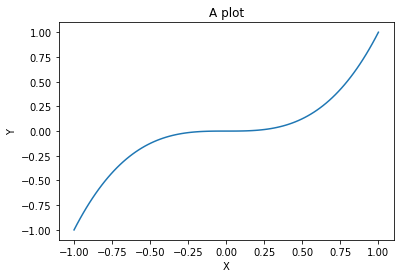

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1, 1, 100)
y = x ** 3
plt.plot(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('A plot')

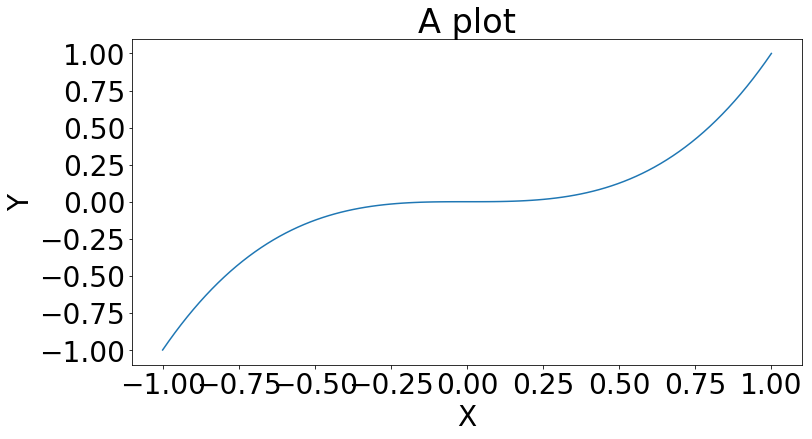

In [25]:
with plt.rc_context(rc={'figure.figsize': (12, 6), 'font.size': 28}):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('A plot')


Personally, I wrap `rc_context` in a function like this one, and use it in most of my notebooks:

In [26]:
def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': True,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)


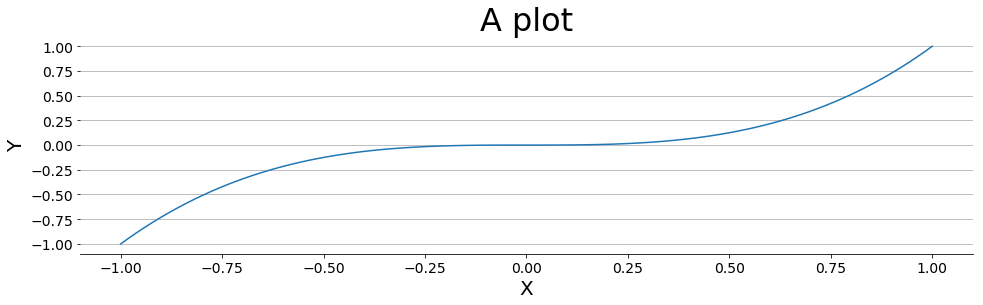

In [27]:
with plot_style(figsize=(16, 4), titlesize=32):
    plt.plot(x, y)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('A plot')


### DB transactions

We can insert some values like this...

In [28]:
import sqlite3

conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano')]
for value in values:
    conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)

result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[(1, 'Pietro'), (2, 'Tiziano')]


But often we want to have a bloc of statements either succeed together, or not be executed at all. For example, in a bank transfer!

In [29]:
conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano'), 'Zbyszek']
for value in values:
    conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)


ProgrammingError: Incorrect number of bindings supplied. The current statement uses 2, and there are 7 supplied.

In [30]:
result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[(1, 'Pietro'), (2, 'Tiziano')]


Using `conn` as a context manager defines a DB transaction: if there is one error, all statements are rolled back and the DB does not change.

In [31]:
conn = sqlite3.connect(':memory:')
conn.execute('CREATE TABLE users (id INT PRIMARY KEY, name CHAR(50))')

values = [(1, 'Pietro'), (2, 'Tiziano'), 'Zbyszek']
with conn:
    for value in values:
        conn.execute('INSERT INTO users(id, name) VALUES (?, ?)', value)


ProgrammingError: Incorrect number of bindings supplied. The current statement uses 2, and there are 7 supplied.

In [32]:
result = conn.execute('SELECT * FROM users')
print(result.fetchall())

[]


### `contextlib.suppress`

`contextlib.suppress` suppresses one or more exceptions while the block of code is executed

In [33]:
from contextlib import suppress
import os

with suppress(FileNotFoundError):
    os.remove('haiku.txt')